<a href="https://colab.research.google.com/github/RaghadAlnouri/Raghad/blob/master/R_Alnouri_NLP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP part 1 homework

We've introduced classic techniques to classify the different posts in the 20newsgroup dataset (Basics.ipynb notebook). The goal is to use one of the classification techniques using embeddings and see if you can outperform the random forest applied to word counts.

Criteria:
- Can you outperform the random forest on word counts?
- Use one of the embedding-based methods to build features for documents, and train a classifier on top of it.
- Describe what kind of mistakes your model makes on the test set. Look at errors in the test set classification. Can you come up with a reason why the model didn't get it? Do you have a hypothesis on how to fix this? Write a short paragraph/few bullet points about the errors that seem to occur and what you would try if you had to fix them.
- Don't build vocabulary using the test set!!!

Some tips:
- Even if using embedding-based models, preprocessing can help.
- Look at the data, can you see anything embeddings will have a hard time with?
- How are you handling Out-of-Vocabulary words?

## Loading data

In [0]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')


In [0]:
X_train, y_train = newsgroups_train['data'], newsgroups_train['target']
X_test, y_test = newsgroups_test['data'], newsgroups_test['target']
target_names = newsgroups_train['target_names']

## Explore the data

In [0]:
print("number of classes:", len(target_names))
print("classes:\n", ", ".join(target_names))

number of classes: 20
classes:
 alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc


In [0]:
import numpy as np

# select random samples from data and print them
indices = np.random.randint(0, len(X_train), 3)
for i in indices:
  print("class: ", target_names[y_train[i]])
  print("example:\n", X_train[i])
  print('*'*50)


class:  comp.windows.x
example:
 From: hsteve@carina.unm.edu ()
Subject: XTranslateCoord. Problem
Organization: University of New Mexico, Albuquerque
Lines: 13
NNTP-Posting-Host: carina.unm.edu

It seems like XTranslateCoord. doesn't work the way I expecting it.  Right
after performs a XMoveWindow, I want to know the absolute window position
with respect to the root window.  To get this info. I do a XTranslateCoordinates
but the abs_x, and abs_y aren't right?  Does anybody know of a way to find 
out this information?

Thanks, please e-mail to hsteve@carina.unm.edu if it's possible

-- 
    _---_     Steve  
   / o o \    hsteve@hydra.unm.edu, hsteve@carina.unm.edu
  | \___/ |   
              Just say NO to VMS!!

**************************************************
class:  comp.os.ms-windows.misc
example:
 From: pmw0@ns1.cc.lehigh.edu (PHILLIP MICHAEL WILLIAMS)
Subject: X Windows for windows
Organization: Lehigh University
Lines: 7

Are there any X window servers that can run under MS-W

## load google word2vec



In [0]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip GoogleNews-vectors-negative300.bin.gz
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(filename, binary=True)

--2020-03-10 17:48:19--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.178.221
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.178.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  48.6MB/s    in 33s     

2020-03-10 17:48:52 (47.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]

gzip: GoogleNews-vectors-negative300.bin already exists; do you wish to overwrite (y or n)? n
	not overwritten


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Data preprocessing

In [0]:
# install missing package
!pip install unidecode


In [0]:
# imports
import nltk
nltk.download('punkt')
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# preprocessing functions

def clean(s):
  s = s.lower()
  s = unidecode(s) # remove accents
  lines = s.split('\n')
  lines = [x for x in lines if len(x) != 0]
  lines = [x for x in lines
           if not (x.startswith('from') or x.startswith('lines') or x.startswith('organization'))]
  return '\n'.join(lines)

stopwords = set(nltk_stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
alphanum = set('qwertyuiopasdfghjklzxcvbnm1234567890')

def tokenize(s):
  tokens = nltk.tokenize.word_tokenize(s)
  
  # remove stopwords
  tokens = [word for word in tokens if word not in stopwords]
  
  # stem or lemmatize words "Didn't improve the performance"
  # tokens = [stemmer.stem(word) for word in tokens]
  # tokens = [lemmatizer.lemmatize(word) for word in tokens]
  
  # remove non alpha-numeric tokens
  tokens = [word for word in tokens
            if all(char in alphanum for char in word)]

  # tokens = [word for word in tokens
  #           if not all(char not in alphanum for char in word)]
  return tokens

# takes some time...
X_train_clean = [clean(x) for x in X_train]
X_test_clean = [clean(x) for x in X_test]

X_train_tok = [tokenize(x) for x in X_train_clean]
X_test_tok = [tokenize(x) for x in X_test_clean]


In [0]:
# take a look at the data
print("original:\n", X_train[0])
print("*" * 50)
print("clean:\n", X_train_clean[0])
print("*" * 50)
print("tokenized:\n", X_train_tok[0])

original:
 From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





**************************************************
clean:
 subject: what car is this!?
nntp-posting-host: rac3.wam.umd.edu
 i was wondering if anyone out there could enlighten me on this car i saw
the other day. it was a 2-door sports car, looked to be from the late 

## Build vocabulary

In [0]:
# list of all words
all_words = [word for sent in X_train_tok for word in sent]

# put them in a set
all_words_set = set(all_words)
print("# all words =", len(all_words_set))

# count words in all_words
from collections import Counter
word_counts = Counter(all_words)

# choose only words with counts >= MIN_COUNT in the text. The list is sorted by word count
MIN_COUNT = 20
vocab_list = [word for word, count in word_counts.most_common() if count >= MIN_COUNT]

# add OOV token to vocab_list, which will have index 0 "Handelling out of vocabulary words"
vocab_list = ['OOV'] + vocab_list
print("# words in vocabulary =", len(vocab_list))

# create a vocabulary and inverse-vocabulary
from collections import OrderedDict
vocab_ind = OrderedDict([(word,i) for i,word in enumerate(vocab_list)])
ind_vocab = vocab_list

# all words = 90927
# words in vocabulary = 9861


In [0]:
# look at first 10 words in our vocab
print(list(vocab_ind.items())[:10])
print(", ".join(["%d:%s" % (i, word) for i, word in enumerate(ind_vocab[:10])]))


[('OOV', 0), ('subject', 1), ('would', 2), ('one', 3), ('writes', 4), ('article', 5), ('1', 6), ('x', 7), ('people', 8), ('like', 9)]
0:OOV, 1:subject, 2:would, 3:one, 4:writes, 5:article, 6:1, 7:x, 8:people, 9:like


In [0]:
# Convert train and test words to integers so we can use embeddings

# def token_to_int(sent):
#   # handle out-of-vocabulary words using OOV token (index 0 in the vocab).
#   return [vocab_ind[word] if word in vocab_ind else 0 for word in sent]

# def int_to_token(sent):
#   return [ind_vocab[i] for i in sent]

# X_train_ind = [token_to_int(sent) for sent in X_train_tok]
# X_test_ind = [token_to_int(sent) for sent in X_test_tok]

# # look at first example
# print(X_train_ind[0])
# print(X_test_ind[0])

## Construct features for data using average word2vec embeddings

In [0]:
import numpy as np

def token_to_feat(sent):
  # note that we will ignore OOV words from the mean features
  feature_array = np.array([word2vec[word] for word in sent if word in word2vec])
  return feature_array.mean(axis=0)

  X_train_feat = np.array([token_to_feat(sent) for sent in X_train_tok])
  X_test_feat = np.array([token_to_feat(sent) for sent in X_test_tok])

# take a look at data
#print(len(X_train_feat))
#print(len(X_test_feat))
print(X_train_feat.shape)
print(X_test_feat.shape)

(11314, 300)
(7532, 300)


## Train a classifier on top of word2vec features

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout

inputs = keras.Input(shape=(300,))
h1 = Dense(units=256, activation='relu')(inputs)
h2 = Dropout(0.5)(h1)
h3 = Dense(units=256, activation='relu')(h2)
h4 = Dropout(0.5)(h3)
outputs = Dense(units=20, activation='softmax')(h4)

learning_rate = 0.001

func_model = keras.Model(inputs, outputs)
func_model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                   optimizer=keras.optimizers.Adam(learning_rate),
                   metrics=[keras.metrics.sparse_categorical_accuracy])
func_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                5140      
Total params: 147,988
Trainable params: 147,988
Non-trainable params: 0
_____________________________________________________

In [0]:
history = func_model.fit(X_train_feat, y_train, validation_data=(X_test_feat, y_test), batch_size=32, shuffle=True, epochs=100)

Train on 11314 samples, validate on 7532 samples
Epoch 1/100
11314/11314 [==============================] - 1s 116us/sample - loss: 2.1068 - sparse_categorical_accuracy: 0.3056 - val_loss: 1.4138 - val_sparse_categorical_accuracy: 0.5252
Epoch 2/100
11314/11314 [==============================] - 1s 110us/sample - loss: 1.3277 - sparse_categorical_accuracy: 0.5354 - val_loss: 1.1668 - val_sparse_categorical_accuracy: 0.6257
Epoch 3/100
11314/11314 [==============================] - 1s 105us/sample - loss: 1.1213 - sparse_categorical_accuracy: 0.6197 - val_loss: 1.0590 - val_sparse_categorical_accuracy: 0.6597
Epoch 4/100
11314/11314 [==============================] - 1s 107us/sample - loss: 1.0077 - sparse_categorical_accuracy: 0.6584 - val_loss: 1.0078 - val_sparse_categorical_accuracy: 0.6743
Epoch 5/100
11314/11314 [==============================] - 1s 105us/sample - loss: 0.9352 - sparse_categorical_accuracy: 0.6876 - val_loss: 0.9907 - val_sparse_categorical_accuracy: 0.6815
Epoch 

In [0]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

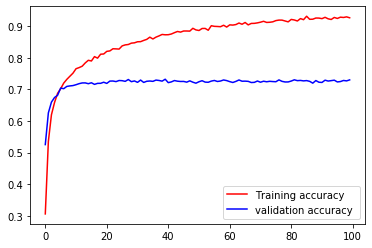

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'], 'r')
plt.plot(history.history['val_sparse_categorical_accuracy'], 'b')
plt.legend(['Training accuracy', 'validation accuracy '])